In [31]:
import json 
import numpy as np 
from tqdm import tqdm 
from pathlib import Path
from collections import defaultdict

def get_prediction(prob_dict_list):
    predicted_toks_and_probs = []
    for timestep, prob_dict in enumerate(prob_dict_list): 
        toks, probs = zip(*prob_dict.items())
        # print(prob_dict['SourceCopy'])
        # best_prob_idx = np.argmax(probs)
        top_k_idxs = np.argpartition(probs, -4)[-4:]
        # best_prob, best_tok = probs[top_k_idxs[0]], toks[top_k_idxs[0]]
        top_probs, top_toks = [probs[x] for x in top_k_idxs], [toks[x] for x in top_k_idxs]
        best_prob_idx = np.argmax(top_probs)
        best_tok, best_prob = top_toks[best_prob_idx], top_probs[best_prob_idx]
        predicted_toks_and_probs.append((best_tok, best_prob, top_probs, top_toks))
    return predicted_toks_and_probs

def check_tokens(pred_tok, tgt_tok, prev_tgts):
    if "SourceCopy" not in pred_tok and "TargetCopy" not in pred_tok:
        return pred_tok == tgt_tok
    elif "SourceCopy" in pred_tok:
        return pred_tok.split("_")[1] == tgt_tok
    else:
        try:
            tok_idx = int(pred_tok.split("_")[1])-1
            return prev_tgts[tok_idx] == tgt_tok
        except IndexError:
            print(len(prev_tgts))
            print(pred_tok)
            print(prev_tgts)
            raise AssertionError
    

def read_json(path): 
    print(f"opening data")
    with open(path) as f1:
        data = json.load(f1)
    print(f"got data")
    return data

def get_probs(data):
    probs_to_ret = defaultdict(list)
    func_ontology = set()

    mistakes, corrects = [], []

    for instance_idx, instance in tqdm(enumerate(data)): 
        instance = instance
        left_context = [x[0] for x in instance['left_context']][1:]
        target_toks = left_context + ["@end@"]
        probs = instance['prob_dist']
        predicted_toks = get_prediction(probs)

        source_tokens = " ".join([x[0] for x in instance['source_tokens']])
        for i in range(len(left_context)):
            input_token = left_context[i]
            output_token = predicted_toks[i][0]
            output_prob = predicted_toks[i][1]
            top_k_tokens = predicted_toks[i][2]
            top_k_probs = predicted_toks[i][3]
            target_token = target_toks[i]
            tokens_are_equal = check_tokens(output_token, target_token, left_context[:i])
            if not tokens_are_equal:
                mistake = {"instance_idx": instance_idx,
                           "source_tokens": source_tokens,
                           "left_context": left_context[0:i],
                           "target_toks": target_toks,
                           "output_token": output_token,
                           "output_prob": output_prob,
                           "top_k_tokens": top_k_tokens,
                           "top_k_probs": top_k_probs,
                           "target_token": target_token}
                mistakes.append(mistake)
            else:
                correct = {"instance_idx": instance_idx,
                           "source_tokens": source_tokens,
                           "left_context": left_context[0:i],
                           "target_toks": target_toks,
                           "output_token": output_token,
                           "output_prob": output_prob,
                           "top_k_tokens": top_k_tokens,
                           "top_k_probs": top_k_probs,
                           "target_token": target_token}
                corrects.append(correct)

    return mistakes, corrects

In [32]:
# data = read_json("/brtx/604-nvme2/estengel/miso_models/tune_roberta//translate_output/dev_valid_losses.json")
data = read_json("/brtx/603-nvme1/estengel/calflow_calibration/tune_roberta_number_tokenize/translate_output/dev_valid_losses.json")

opening data
got data


In [33]:
mistakes, corrects = get_probs(data)

6882it [00:26, 263.18it/s]


In [34]:
from collections import Counter
print(len(mistakes))
print(len(corrects))

mistake_examples = len(set([x['instance_idx'] for x in mistakes])) 
correct_examples = len(set([x['instance_idx'] for x in corrects]))

mistake_idxs = [x['instance_idx'] for x in mistakes]
mistake_counter = Counter(mistake_idxs)
mistake_only_once = [x for x in mistake_counter if mistake_counter[x] == 1]
print(f"{len(mistake_only_once)} of {mistake_examples} ({len(mistake_only_once)/mistake_examples*100:.2f}%) examples have one mistake only")
print(f"number of unique failures: {len(mistakes)}")
print("number of failure examples: " +  str(mistake_examples))
print("number of correct examples: " +  str(correct_examples)) 

print(f"accuracy: {correct_examples/(correct_examples+mistake_examples)}")

print(f"mistakes per mistake example: {len(mistakes)/mistake_examples}")


1814
89909
962 of 1277 (75.33%) examples have one mistake only
number of unique failures: 1814
number of failure examples: 1277
number of correct examples: 6882
accuracy: 0.8434857212893737
mistakes per mistake example: 1.4205168363351606


In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 



In [35]:
mistake_probs = [x['output_prob'] for x in mistakes]
correct_probs = [x['output_prob'] for x in corrects]


print(np.mean(mistake_probs))
print(np.mean(correct_probs))

# prob_df = pd.DataFrame(columns=['prob', 'correct'])
prob_df_data = []
for prob in mistake_probs:
    prob_df_data.append({'prob': prob, 'correct': False}) 
for prob in correct_probs:
    prob_df_data.append({'prob': prob, 'correct': True}) 


prob_df = pd.DataFrame(prob_df_data)





0.8100887148783777
0.9931453792587237


In [36]:
import scipy 
from collections import Counter

values, bin_edges, bin_number = scipy.stats.binned_statistic(prob_df['prob'], 
                                                             prob_df['correct'], 
                                                             statistic='mean', 
                                                             bins=20)
bin_lookup = Counter(bin_number)

    prob_model  prob_correct  count  log_count
0     0.189277      0.166667    NaN   1.791759
1     0.229813      0.000000    NaN   1.945910
2     0.270349      0.100000    NaN   2.302585
3     0.310885      0.346154    NaN   3.258097
4     0.351421      0.260870    NaN   3.135494
5     0.391957      0.413043    NaN   3.828641
6     0.432493      0.403846    NaN   3.951244
7     0.473029      0.481132    NaN   4.663439
8     0.513565      0.473054    NaN   5.117994
9     0.554101      0.518072    NaN   5.111988
10    0.594637      0.539773    NaN   5.170484
11    0.635173      0.560811    NaN   4.997212
12    0.675709      0.620879    NaN   5.204007
13    0.716245      0.656716    NaN   5.303305
14    0.756782      0.679012    NaN   5.493061
15    0.797318      0.700337    NaN   5.693732
16    0.837854      0.756098    NaN   5.910797
17    0.878390      0.781447    NaN   6.455199
18    0.918926      0.839933    NaN   7.079184
19    0.959462      0.993065    NaN  11.381392


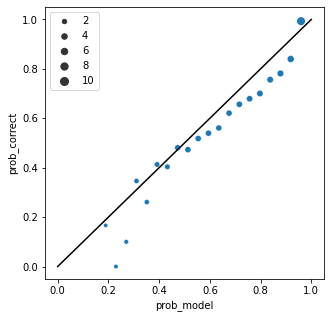

In [38]:
fig, ax = plt.subplots(figsize=(5,5))

df_to_plot = pd.DataFrame(columns=["prob_model", "prob_correct", "count"])
for i, (val, edge, bin_num) in enumerate(zip(values, bin_edges, bin_number)):
    df_to_plot = df_to_plot.append({"prob_model": edge, 
                                    "prob_correct": val, 
                                    "log_count": np.log(bin_lookup[i+1])}, 
                                    ignore_index=True)


sns.scatterplot(data=df_to_plot, x = "prob_model", y="prob_correct", size="log_count", ax=ax, legend='brief')
xs_line = np.linspace(0,1,2)
ys_line = xs_line
sns.lineplot(x = xs_line, y=ys_line, ax=ax, color='black')

print(df_to_plot)

In [40]:
np.random.seed(12)
# inspect mistakes 
# sample 10 from across the range of mistakes
n_bins = 20
values, bins, bin_number = scipy.stats.binned_statistic([x['output_prob'] for x in mistakes], [x['output_prob'] for x in mistakes], statistic='mean', bins=n_bins)

for i in range(1, len(bins)):
    bin_mistakes = [x for j, x in enumerate(mistakes) if bin_number[j] == i]
    if len(bin_mistakes) == 0:
        print(i)
        print(bin_number[0:10])

    mistake = np.random.choice(bin_mistakes, size=1)[0]
    print(f"Source: {mistake['source_tokens']}")
    print(f"Left context: {mistake['left_context']}")
    print(f"TARGET: {mistake['target_toks']}")
    print(f"PRED TOK {mistake['output_token']}")
    print(f"TOP PREDS: {mistake['top_k_tokens']}")
    print(f"TOP PROBS: {mistake['top_k_probs']}")
    print(f"TRUE TARGET: {mistake['target_token']}")
    print("")


Source: __User create a meeting 0907 tomorrow
Left context: ['@ROOT@', 'Yield', 'CreateCommitEventWrapper', 'CreatePreflightEventWrapper', 'Event.start_?', '?=', 'DateAtTimeWithDefaults', 'HourMinuteMilitary', 'Long']
TARGET: ['@ROOT@', 'Yield', 'CreateCommitEventWrapper', 'CreatePreflightEventWrapper', 'Event.start_?', '?=', 'DateAtTimeWithDefaults', 'HourMinuteMilitary', 'Long', '7', 'Long', '9', 'Tomorrow', '@end@']
TOP PREDS: [0.06558316200971603, 0.20700158178806305, 0.12271514534950256, 0.2101268768310547]
TOP PROBS: ['45', '0', '9', '59']
TRUE TARGET: 7

Source: __User change the golf playing time __Agent Could you be more specific with your request ? __User Okay , can you just tell me how windy it 's going to be and if they 'll be any clouds ?
Left context: ['@ROOT@', 'Yield', 'and']
TARGET: ['@ROOT@', 'Yield', 'and', 'IsCloudy', 'IsWindy', 'WeatherForEvent', 'WeatherForEvent', 'Execute', 'refer', 'extensionConstraint', 'EmptyStructConstraint', 'Event', '@end@']
TOP PREDS: [0.0

In [ ]:
import scipy
from scipy import stats
np.random.seed(12)
# lets look at inputs for 100 mistakes 
n_bins = 100
values, bins, bin_number = scipy.stats.binned_statistic([x['output_prob'] for x in mistakes], [x['output_prob'] for x in mistakes], statistic='mean', bins=n_bins)

for i in range(1, len(bins)):
    bin_mistakes = [x for j, x in enumerate(mistakes) if bin_number[j] == i and mistake_counter[x['instance_idx']] == 1]
    if len(bin_mistakes) == 0:
        continue
    mistake = np.random.choice(bin_mistakes, size=1)[0]
    utt = mistake['source_tokens'].split("__User")[-1]
    print(f"{utt}, {mistake['output_token']}, {mistake['target_token']}, {mistake['output_prob']:.3f}")

 No I want it to start 08 h05, 23, 5, 0.189
 What does my schedule say for 12|58 on Sunday ?, 30, 58, 0.236
 Put a conference tomorrow from 6 to8, 10, 8, 0.266
 22 A MAHAL, FenceScope, PleasantryAnythingElseCombined, 0.278
 After my last night cap next week , add lay in bed trying to sleep, SourceCopy_to, Event.subject_?, 0.286
 Add Decide who is my 2 nd Friend to my calendar, FenceScope, Yield, 0.290
 Now I need to delete something else, PleasantryCalendar, FenceOther, 0.319
 Before or after the octopus lands ., FenceOther, FenceDateTime, 0.321
 Can you remove Megan Bowen and send her a message, Yield, FenceOther, 0.335
 Is there an entry for doctor 's appointments ?, FenceScope, Yield, 0.338
 Create an event for Big Sandwich Regret immediately following my 10 AM appointment ., EventAtTime, EventOnDateTime, 0.343
 How about the first one ., FenceOther, PleasantryAnythingElseCombined, 0.363
 yes, PleasantryCalendar, PleasantryAnythingElseCombined, 0.369
 Yes , but have it start at 900,

(0.995, 1.0)

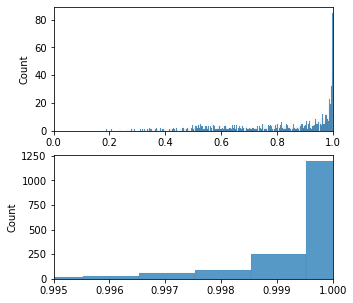

In [ ]:
# What percentage of mistakes are low probability? 
# What percentage of correct are high probability? 

mistake_probs = [x['output_prob'] for x in mistakes]
correct_probs = [x['output_prob'] for x in corrects]
correct_probs = np.random.choice(correct_probs, size = len(mistake_probs), replace=False)
fig, ax = plt.subplots(2,1, figsize=(5,5), sharex=False, sharey=False)
sns.histplot(mistake_probs, ax=ax[0], binwidth=0.001)
sns.histplot(correct_probs, ax=ax[1], binwidth=0.001)
ax[0].set_xlim(0.0, 1.0)
ax[1].set_xlim(0.995, 1.0)



In [ ]:
# what's the optimal threshold? 

def compute_f1(df, thresh, downsample=True, min_sample_size=1000):
    pred_mistakes = df[df['prob'] < thresh]
    pred_corrects = df[df['prob'] >= thresh]
    if len(pred_mistakes) < min_sample_size or len(pred_corrects) < min_sample_size:
        return [0, 0, 0, 0]
    if downsample:
        min_len = min(len(pred_mistakes), len(pred_corrects))
        pred_mistakes = pred_mistakes.sample(n=min_len, replace=False)
        pred_corrects = pred_corrects.sample(n=min_len, replace=False)


    false_negatives = len(pred_mistakes[pred_mistakes['correct'] == True])
    false_positives = len(pred_corrects[pred_corrects['correct'] == False])
    true_positives = len(pred_corrects[pred_corrects['correct'] == True])
    true_negatives = len(pred_mistakes[pred_mistakes['correct'] == False])
    try:
        precision = true_positives/(true_positives + false_positives)
    except ZeroDivisionError:
        precision = 0
    try:
        recall = true_positives/(true_positives + false_negatives)
    except ZeroDivisionError:
        recall = 0
    try:
        f1 = 2*precision*recall/(precision + recall)
    except ZeroDivisionError:
        f1 = 0


    accuracy = (true_positives + true_negatives)/(true_positives + true_negatives + false_positives + false_negatives)
    return [f1, precision, recall, accuracy]

threshes = np.arange(0.00, 1.0, 0.01)
f1s = [[thresh] + compute_f1(prob_df, thresh) for thresh in threshes]

# why is this so low, seems like 0.49 misses most of the true negatives
# F1 score doesn't take true negatives into account; since there are a lot more correct than mistake, 
# maybe classifying everything as correct isn't that bad
# we get 0.0.98 precision, 1.0 recall by setting threshold to 0.0; that's not good 
best_thresh_f1, *best_f1 = max(f1s, key=lambda x: x[1])
best_thresh_acc, *best_acc = max(f1s, key=lambda x: x[-1])
print("f1", best_thresh_f1, best_f1)
print(f"accuracy", best_thresh_acc, best_acc)


# so anything less than 0.995 confidence can safely be said to be a mistake, with 0.94 F1 (pretty good), super high precision, lower recall 

f1 0.7000000000000001 [0.7948618139353834, 0.9855212355212355, 0.6660143509458578, 0.7456563706563707]
accuracy 0.7000000000000001 [0.7948618139353834, 0.9855212355212355, 0.6660143509458578, 0.7456563706563707]


In [ ]:
print(len(prob_df))

91717
